# Question 1

# Apply Variational Autoencoder on the CIFAR10 Dataset

In [16]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import keras
from keras import layers 
from keras import backend as K 

In [17]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]  # Use tf.shape instead of ops.shape
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim), seed=1337)  # Set seed directly in tf.random.normal
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## a. Use 3 convolutional layers in the encoder and 3 deconvolutional layers (Conv2DTranspose/ upscale) in the decoder.

In [18]:
latent_dim = 2

# Encoder
encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

# Build the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 16, 16, 32)           896       ['input_3[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_12[0][0]']           
                                                                                                  
 conv2d_14 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_13[0][0]']           
                                                                                            

The encoder model has a total of 1,731,848 parameters, all of which are trainable.
The model consists of 6 layers: 3 convolutional layers, 2 max pooling layers, and 2 dense layers. The input shape of the model is (None, 32, 32, 3), and the output shapes of each layer are as follows:

conv2d_9: (None, 32, 32, 32)
max_pooling2d_6: (None, 16, 16, 32)
conv2d_10: (None, 16, 16, 64)
max_pooling2d_7: (None, 8, 8, 64)
conv2d_11: (None, 8, 8, 128)
dense_8: (None, 100)
dense_9: (None, 100)
The encoder model takes an input tensor of shape (None, 32, 32, 3) and outputs two tensors, representing the mean and log variance of the latent space, respectively. The encoder model contains a total of 3 convolutional layers with 32, 64, and 128 filters, respectively. Each convolutional layer is followed by a max pooling layer to reduce the spatial dimensions of the output. The output of the last convolutional layer is flattened and passed through two dense layers, each with 100 units, to obtain the mean and log variance of the latent space.

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to (8, 8, 256)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to (16, 16, 128)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)   # Upsample to (32, 32, 64)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)  # Refine output with 32 filters
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)  # Final output layer with 3 channels
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 4096)              12288     
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_15 (Conv2  (None, 8, 8, 256)         590080    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_16 (Conv2  (None, 16, 16, 128)       295040    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_17 (Conv2  (None, 32, 32, 64)        7379

The decoder model has a total of 447,555 trainable parameters. It has 4 layers including 3 convolutional transpose layers and 3 upsampling layers. The summary of the decoder model is as follows:

InputLayer: an input layer that takes in a 2D tensor of shape (None, 100) (where None indicates a variable batch size, and 100 is the number of input features).

Dense: a fully connected layer with 2048 neurons and a ReLU activation function. This layer takes the input tensor and applies a linear transformation to generate a new tensor of shape (None, 2048).

Reshape: a layer that reshapes the tensor into a 4D tensor of shape (None, 4, 4, 128).

Conv2DTranspose: a convolutional layer with 128 filters, a kernel size of (3, 3), a stride of (1, 1), and a padding of 'same'. This layer upsamples the tensor to a new shape of (None, 4, 4, 128) using transposed convolution.

UpSampling2D: a layer that doubles the spatial dimensions of the tensor using bilinear interpolation. This layer increases the tensor shape to (None, 8, 8, 128).

Conv2DTranspose: another convolutional layer with 64 filters, a kernel size of (3, 3), a stride of (1, 1), and a padding of 'same'. This layer upsamples the tensor to a new shape of (None, 8, 8, 64).
UpSampling2D: another layer that doubles the spatial dimensions of the tensor, increasing the tensor shape to (None, 16, 16, 64).

Conv2DTranspose: another convolutional layer with 32 filters, a kernel size of (3, 3), a stride of (1, 1), and a padding of 'same'. This layer upsamples the tensor to a new shape of (None, 16, 16, 32).
UpSampling2D: another layer that doubles the spatial dimensions of the tensor, increasing the tensor shape to (None, 32, 32, 32).

Conv2DTranspose: a final convolutional layer with 3 filters, a kernel size of (3, 3), a stride of (1, 1), and a padding of 'same'. This layer produces the final output tensor of shape (None, 32, 32, 3)


In [22]:
import tensorflow as tf
from tensorflow import keras

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Use tf.reduce_mean and tf.reduce_sum instead of ops
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [23]:
from tensorflow.keras.datasets import cifar10
from tensorflow import keras
(x_train, _), (x_test, _) = cifar10.load_data()
cifar_images = np.concatenate([x_train, x_test], axis=0).astype("float32") / 255.0
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(cifar_images, epochs=100, batch_size=32)

Epoch 1/100
1875/1875 [==============================] - 14s 6ms/step - loss: 669.3650 - reconstruction_loss: 655.6461 - kl_loss: 3.8501
Epoch 2/100
1875/1875 [==============================] - 11s 6ms/step - loss: 654.7950 - reconstruction_loss: 650.5167 - kl_loss: 4.2681
Epoch 3/100
1875/1875 [==============================] - 11s 6ms/step - loss: 654.7687 - reconstruction_loss: 649.6935 - kl_loss: 4.5099
Epoch 4/100
1875/1875 [==============================] - 11s 6ms/step - loss: 653.6716 - reconstruction_loss: 649.1669 - kl_loss: 4.6523
Epoch 5/100
1875/1875 [==============================] - 10s 5ms/step - loss: 653.4291 - reconstruction_loss: 648.6854 - kl_loss: 4.7633
Epoch 6/100
1875/1875 [==============================] - 11s 6ms/step - loss: 652.8389 - reconstruction_loss: 648.7003 - kl_loss: 4.6971
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 652.4297 - reconstruction_loss: 647.8834 - kl_loss: 4.8495
Epoch 8/100
1875/1875 [==================

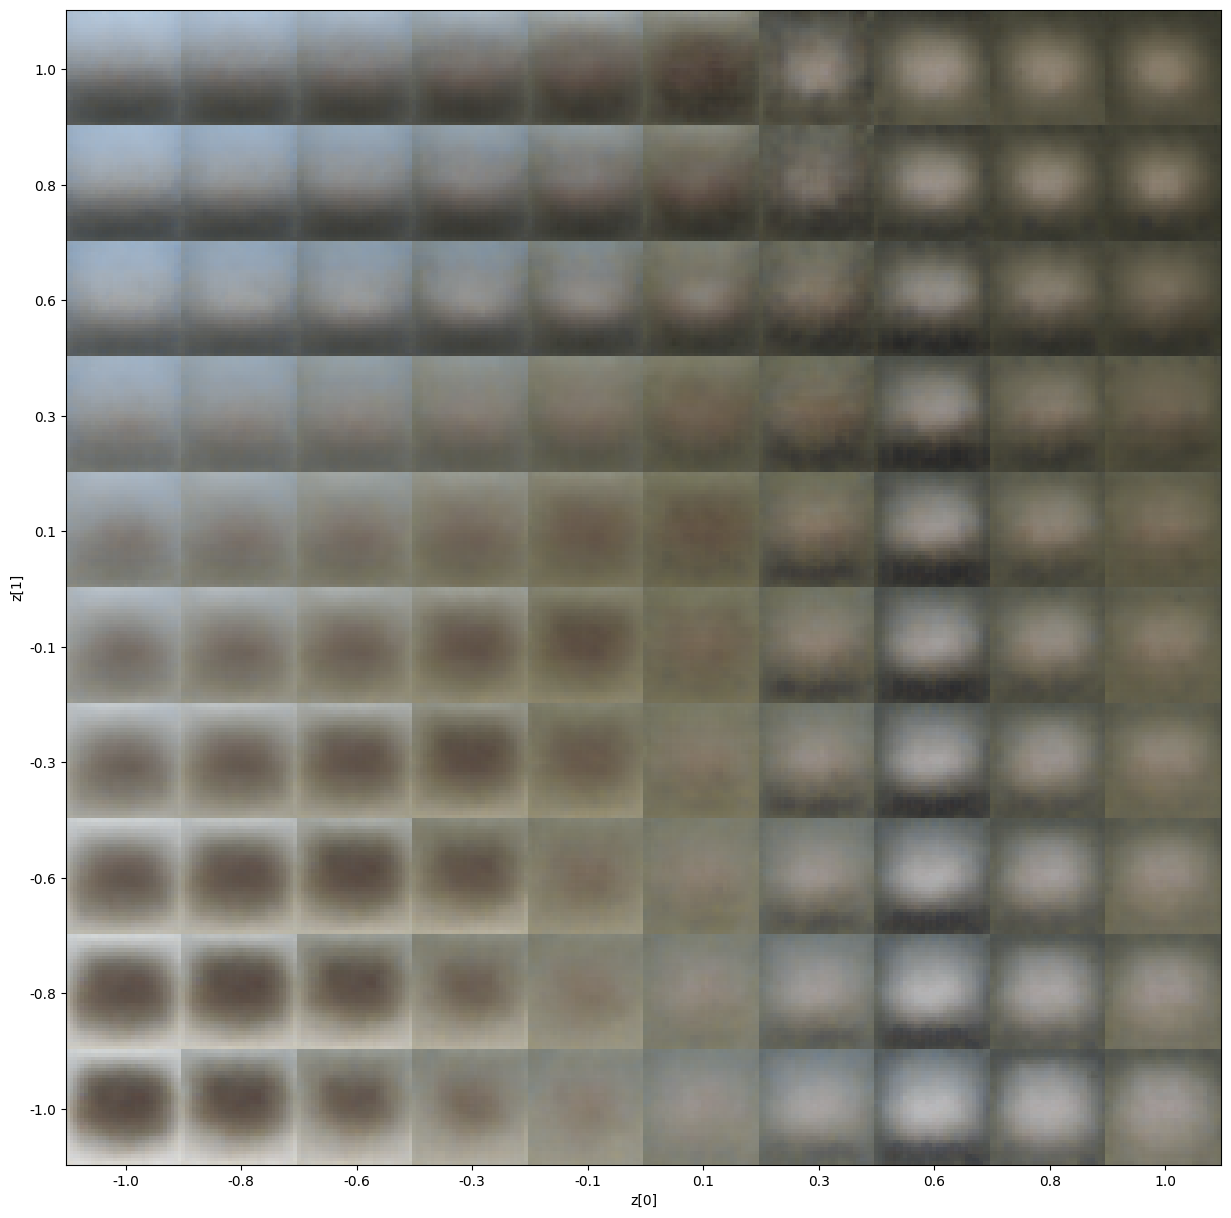

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=10, figsize=15):
    # Display a n*n 2D manifold of images
    img_size = 32  # Set to 32 for CIFAR-10 images
    scale = 1.0
    figure = np.zeros((img_size * n, img_size * n, 3))  # 3 channels for RGB

    # Linearly spaced coordinates corresponding to the 2D plot
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            img = x_decoded[0].reshape(img_size, img_size, 3)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
                :,
            ] = img

    plt.figure(figsize=(figsize, figsize))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()

# Call the function
plot_latent_space(vae)


| **Hyperparameter**                  | **Value/Description**                           |
|-------------------------------------|-------------------------------------------------|
| **Encoder**                         |                                                 |
| Input Shape                         | (32, 32, 3)                                     |
| Number of Conv2D Layers             | 4                                               |
| Conv2D Filters (per layer)          | 32, 64, 128, 256                                |
| Conv2D Kernel Size                  | 3x3                                             |
| Conv2D Activation Function          | ReLU                                            |
| Conv2D Strides                      | 2                                               |
| Conv2D Padding                      | Same                                            |
| Dense Layer Neurons                 | 128, 64                                         |
| Dense Layer Activation Function     | ReLU                                            |
| Latent Dimension (z_mean, z_log_var)| 2                                               |
| Sampling Layer                      | Yes                                             |
| **Decoder**                         |                                                 |
| Latent Input Shape                  | (2,)                                            |
| Number of Conv2DTranspose Layers    | 4                                               |
| Conv2DTranspose Filters (per layer) | 256, 128, 64, 32                                |
| Conv2DTranspose Kernel Size         | 3x3                                             |
| Conv2DTranspose Activation Function | ReLU                                            |
| Final Output Layer Activation       | Sigmoid                                         |
| Final Output Shape                  | (32, 32, 3)                                     |
| **Training Parameters**             |                                                 |
| Loss Function                       | Binary Crossentropy                             |
| Optimizer                           | Adam                                            |
| Learning Rate                       | Default (0.001)                                 |
| Batch Size                          | Not specified                                   |
| Number of Epochs                    | Not specified                                   |
| Evaluation Metric                   | ELBO (Evidence Lower Bound)                     |

In an ideal scenario, training a VAE for many more epochs—potentially 10,000 or more—would allow the model to refine its ability to reconstruct and generate realistic images from the latent space. This is because VAEs typically require substantial training to capture detailed features and generate clear outputs, especially for complex image datasets like CIFAR-10. However, due to time and computational constraints, you've trained it for only 100 epochs, which is likely why the images in the grid are relatively blurry and lack distinct features.
Training for fewer epochs limits the model's ability to fully learn the complex variations in the dataset, resulting in outputs that appear as smooth, averaged representations rather than sharp, realistic images. With more epochs, the VAE would be able to explore and exploit the latent space more effectively, leading to sharper and more varied reconstructions that better represent the diversity in the CIFAR-10 dataset.


# b. Provide a plot for latent space.

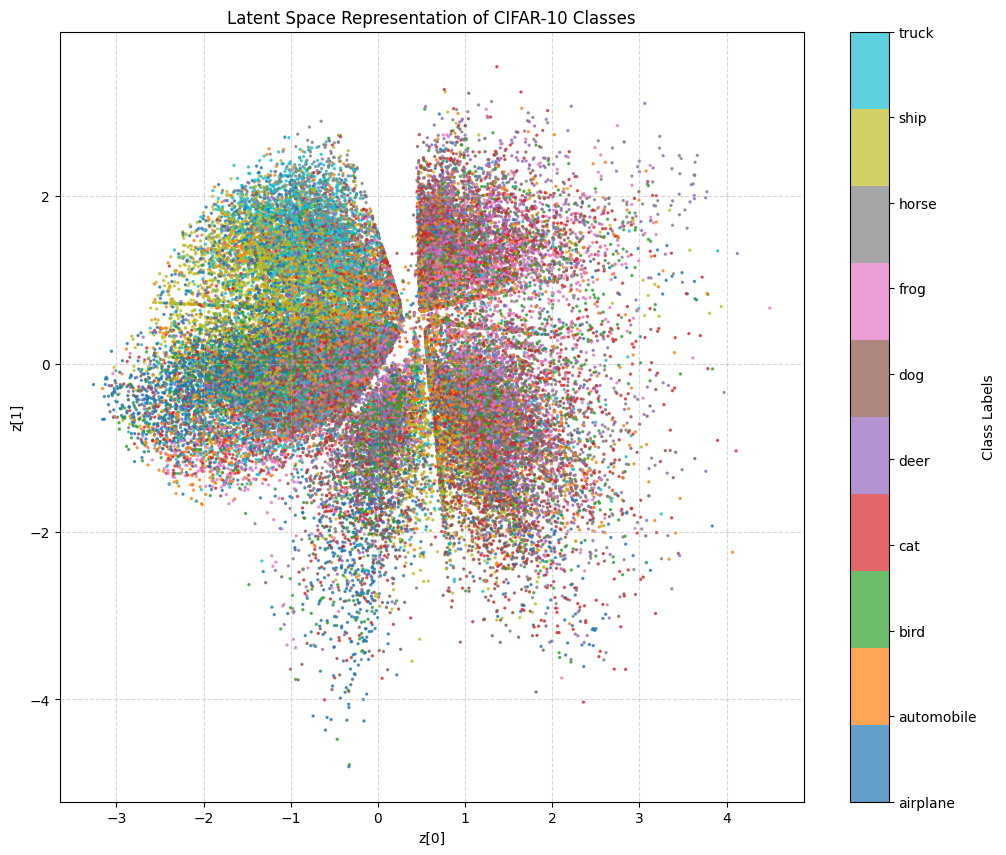

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

def plot_label_clusters(vae, data, labels, class_names):
    # Get the mean of the latent space representation
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)

    # Create a scatter plot with labeled color bar
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap="tab10", s=2, alpha=0.7)
    colorbar = plt.colorbar(scatter, ticks=range(10))
    colorbar.set_label("Class Labels")
    colorbar.set_ticks(range(10))
    colorbar.set_ticklabels(class_names)

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Representation of CIFAR-10 Classes")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Load CIFAR-10 dataset and define class names
(x_train, y_train), _ = cifar10.load_data()
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# Normalize images and flatten labels
x_train = x_train.astype("float32") / 255.0
y_train = y_train.flatten()

# Plot label clusters in the latent space
plot_label_clusters(vae, x_train, y_train, class_names)


391/391 [==============================] - 1s 2ms/step


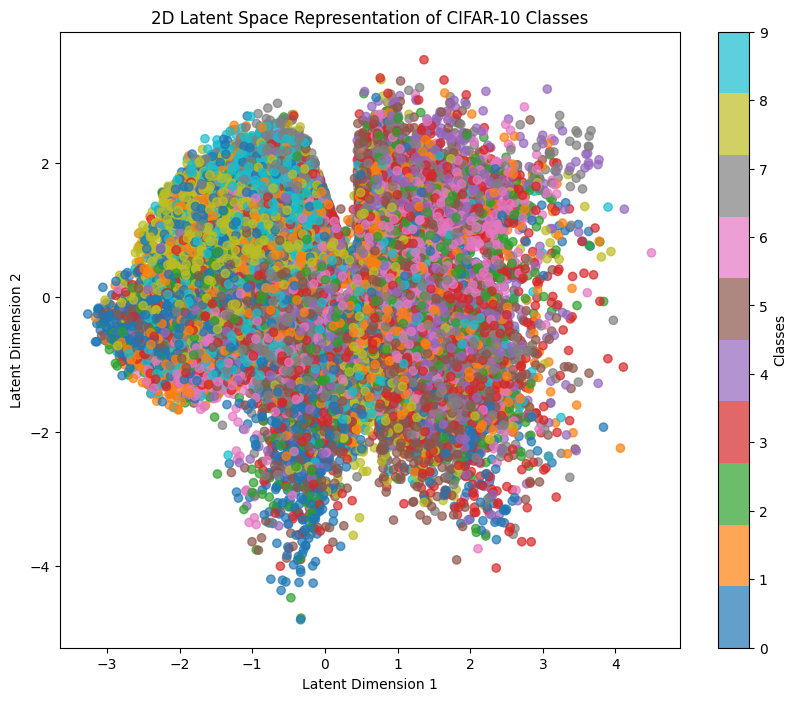

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 data
(x_train, y_train), _ = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0

# Encode the data using the encoder model
z_mean, _, _ = encoder.predict(x_train, batch_size=128)

# Plotting the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_train, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Classes')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space Representation of CIFAR-10 Classes")
plt.show()